In [1]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

from pathlib import Path

In [2]:
def save_history(net, W_history, b_history):
    W_history.append(net[0].weight.clone().detach())
    b_history.append(net[0].bias.clone().detach())

In [3]:
def plot_hyperplanes(W, b, x=None, title='Parameters'):
    if W.shape[1] != 1:
        return

    n_neurons_output, n_neurons_input = W.shape

    for i in range(n_neurons_output):
        n = W[i]
        m = b[i]

        plt.plot(x, n*x + m)
    plt.title(title)
    plt.show()

In [4]:
domain_min, domain_max = 0, torch.pi

def init_net(layer=[1] + [10] + [1]):
    modules = []
    for i in range(len(layer)-2):
        modules.append(nn.Linear(layer[i], layer[i+1]))
        modules.append(nn.Tanh())
    
    modules.append(nn.Linear(layer[-2], layer[-1], bias=False)) 
    
    net = nn.Sequential(*modules)
    
    return net

In [5]:
def derivative(fun, x, **kwargs):
    return torch.autograd.grad(
        fun, x, 
        grad_outputs=torch.ones(fun.shape),
        create_graph=True,
        retain_graph=True,
        allow_unused=True,
        **kwargs
    )


def jacobian(fun, x, **kwargs):
    return torch.autograd.functional.jacobian(
        fun, x,
        create_graph=True
    )


def pinns_loss(n_points, f, net):
    ''' d^2/dx u = f(x) '''
    x = domain_min + torch.rand(n_points) * (domain_max - domain_min)
    
    xx = x.unsqueeze(dim=1)
    xx.requires_grad = True
    
    netx = net(xx)
    
    du_x = derivative(netx, xx)[0]
    ddu_x = derivative(du_x, xx)[0]
    
    error_pde = ((ddu_x.squeeze() - f(x))**2).mean()
    error_bdc = (net(torch.Tensor([domain_min]))**2)[0] + (net(torch.Tensor([domain_max]))**2)[0]

    return error_pde + error_bdc

def pinns_loss_perfect_fit_grad(n_points, f, net):
    x = domain_min + torch.rand(n_points) * (domain_max - domain_min)

    def aux_loss(W):
        ''' d^2/dx u = f(x) '''        
        xx = x.unsqueeze(dim=1)
        xx.requires_grad = True
        
        layer0 = net[1](net[0](xx))
        layer1 = layer0 @ W.T
        
        du_x = derivative(layer1, xx)[0]
        ddu_x = derivative(du_x, xx)[0]

        error_pde = ((ddu_x.squeeze() - f(x))**2).mean()
        error_bdc_1 = (net[1](net[0](torch.Tensor([domain_min])))  @ W.T)**2
        error_bdc_2 = (net[1](net[0](torch.Tensor([domain_max])))  @ W.T)**2
        
        return error_pde + error_bdc_1 + error_bdc_2

    W = net[-1].weight

    dloss_dW = torch.func.jacrev(aux_loss)

    C = (f(x)**2).mean()
    B = dloss_dW(torch.zeros_like(W)).squeeze()
    A = 0.5 * torch.func.jacfwd(dloss_dW)(torch.zeros_like(W)).squeeze()
    
    W = -0.5 * torch.linalg.solve(A, B)

    net[-1].weight = nn.Parameter(W.unsqueeze(dim=0))
    
    return W @ A @ W.T + W @ B + C


def pinns_loss_with_perfect_fit(n_points, f, net):
    ''' d^2/dx u = f(x) (NOT WORKING) '''
    x = domain_min + torch.rand(n_points) * (domain_max - domain_min)
    x.requires_grad = True

    xx = torch.unsqueeze(x, 1) #  .view(-1, 1)
    
    sigma = lambda a: net[1](net[0](a))

    d_sigma = lambda a: jacobian(sigma, a).sum(dim=2).squeeze()
    print('d_sigma.shape', d_sigma(xx).shape)
    print('d_sigma', d_sigma(xx))

    dd_sigma = jacobian(lambda a: d_sigma(a), xx).sum(dim=2).squeeze().T
    print('dd_sigma.shape', dd_sigma.shape)

    print('dd_sigma', dd_sigma)
    
    #  Apply perfect fit
    W0 = net[0].weight.detach().flatten()
    print('W0.shape', W0.shape)
    
    w0w0T = W0 @ W0
    print('w0w0T', w0w0T)
    
    A = w0w0T * (dd_sigma @ dd_sigma.T)
    B = 0.5 * w0w0T * (dd_sigma @ f(x))
    C = (f(x)*f(x)).sum()

    #  Compute loss with L = w1 A w1^T + B w1 + C
    net[-1].weight = nn.Parameter(-0.5 * torch.linalg.solve(A, B))
    
    error_pde = net[1].weight @ A @ net[1].weight.T + net[1].weight @ B + C
    error_bdc = (net(torch.Tensor([0]))**2)[0] + (net(torch.Tensor([torch.pi]))**2)[0]

    return error_pde + error_bdc

In [6]:
eval_points = torch.linspace(domain_min, domain_max, 100)

def train(epochs, n_points, f, u, net, optim, W_history, b_history, name='', report_freq=1000):
    save_history(net, W_history, b_history)
    
    for epoch in range(epochs):
        if epoch % report_freq == 0:
            net.eval()
            with torch.no_grad():
                plt.plot(eval_points, net(eval_points.view(-1, 1)).detach().numpy())
                plt.plot(eval_points, u(eval_points), 'r--')
                plt.title(f'Epoch {epoch} -- {name}')
                plt.show()

        net.train()
        # loss = pinns_loss(n_points, f, net)
        loss = pinns_loss_perfect_fit_grad(n_points, f, net)
        loss.backward()

        optim.step()
        optim.zero_grad()
        
        print(f'epoch {epoch} -- loss {loss}', end='\n' if epoch % report_freq == 0 else '\r')
    
    plt.plot(eval_points, net(eval_points.view(-1, 1)).detach().numpy())
    plt.plot(eval_points, u(eval_points), 'r--')
    plt.title(f'Epoch Final -- {name}')
    plt.show()
    
    save_history(net, W_history, b_history)

In [7]:
layer = [1] + [10] + [1]
lr = 1e-3

#  Glorot (normal)

W_glorot_normal = torch.zeros((layer[1], layer[0]))
b_glorot_normal = torch.zeros(layer[1])

nn.init.xavier_normal_(W_glorot_normal, gain=nn.init.calculate_gain('tanh'))

W_glorot_normal_history = []
b_glorot_normal_history = []

#  He (normal)

W_he_normal = torch.zeros((layer[1], layer[0]))
b_he_normal = torch.zeros(layer[1])

nn.init.kaiming_normal_(W_he_normal, mode='fan_out', nonlinearity='tanh')

W_he_normal_history = []
b_he_normal_history = []

#  Equidistant

W_equidistant = torch.ones((layer[1], layer[0]))
b_equidistant = -torch.linspace(domain_min, domain_max, layer[1])

W_equidistant_history = []
b_equidistant_history = []


init_data = [
    (W_glorot_normal, b_glorot_normal, W_glorot_normal_history, b_glorot_normal_history, 'glorot_normal'),
    (W_he_normal, b_he_normal, W_he_normal_history, b_he_normal_history, 'he_normal'),
    (W_equidistant, b_equidistant, W_equidistant_history, b_equidistant_history, 'equidistant')
]

In [8]:
epochs = 5000
n_points = 200
u = lambda x: torch.sin(3*x)
f = lambda x: -9*torch.sin(3*x)

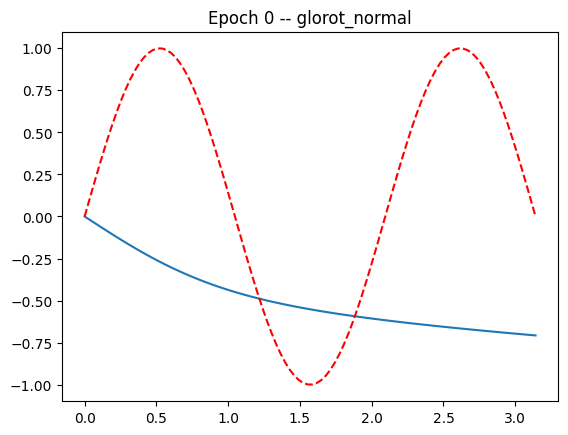

/tmp/ipykernel_11978/276641911.py:68: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  return W @ A @ W.T + W @ B + C


epoch 0 -- loss -3.125774383544922
epoch 499 -- loss 14.918121337890625485

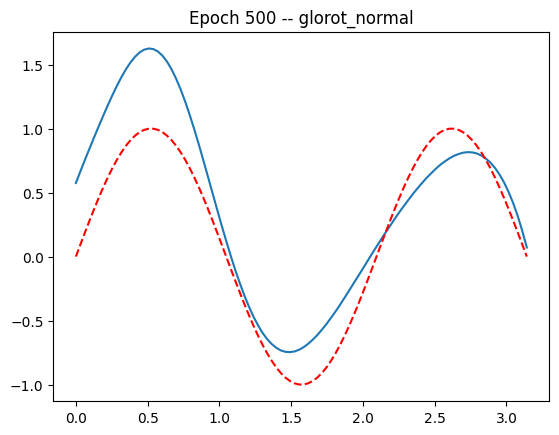

epoch 500 -- loss -45.98540496826172
epoch 999 -- loss 1.177669525146484445

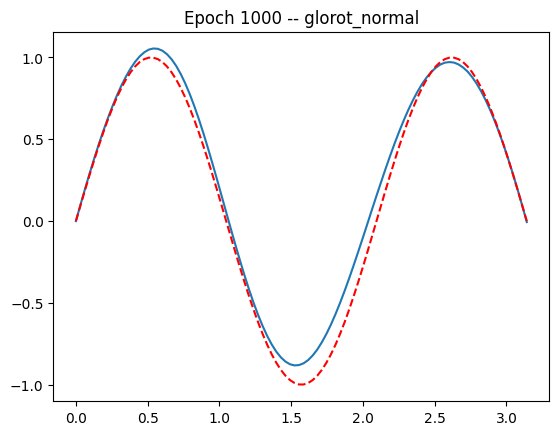

epoch 1000 -- loss -9.877696990966797
epoch 1499 -- loss 0.9596862792968756525

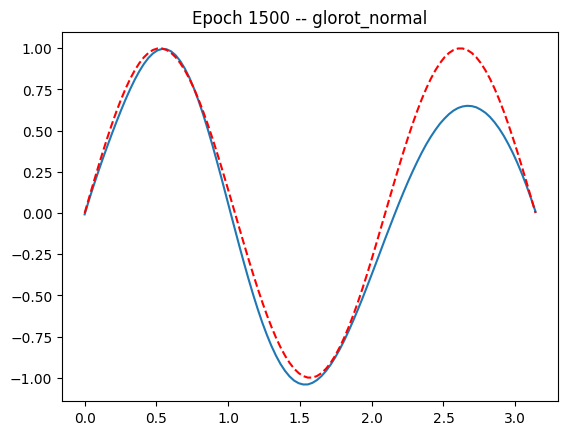

epoch 1500 -- loss 4.854824066162109
epoch 1999 -- loss -11.91111755371093855

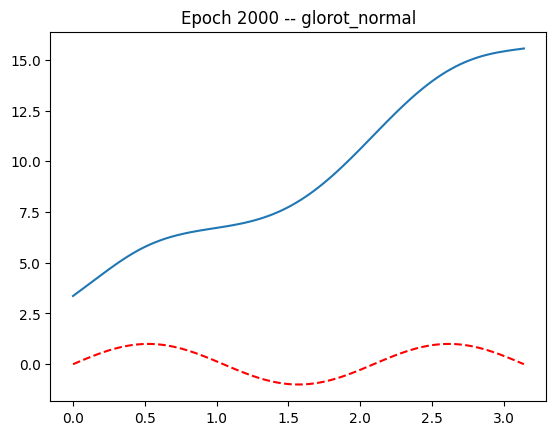

epoch 2000 -- loss 1.6153678894042969
epoch 2499 -- loss -1.062866210937506625

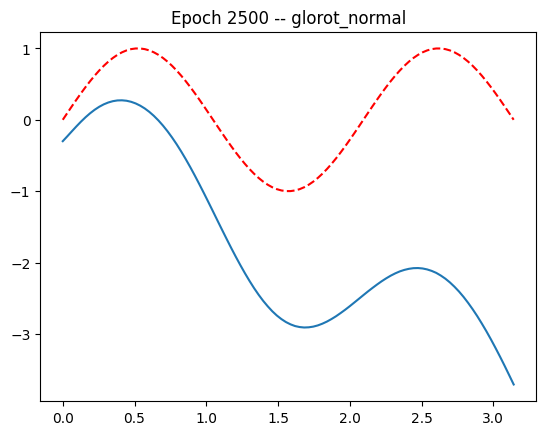

epoch 2500 -- loss 1.1960983276367188
epoch 2999 -- loss 1.211791992187518865

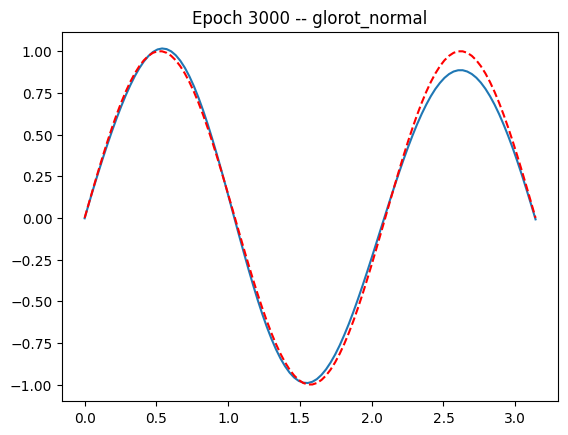

epoch 3000 -- loss 19.964481353759766
epoch 3499 -- loss 1.0675582885742188425

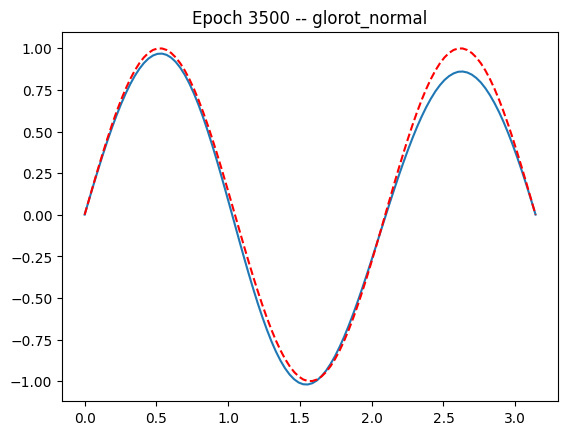

epoch 3500 -- loss 39.16377258300781
epoch 3999 -- loss -2.98403549194335942

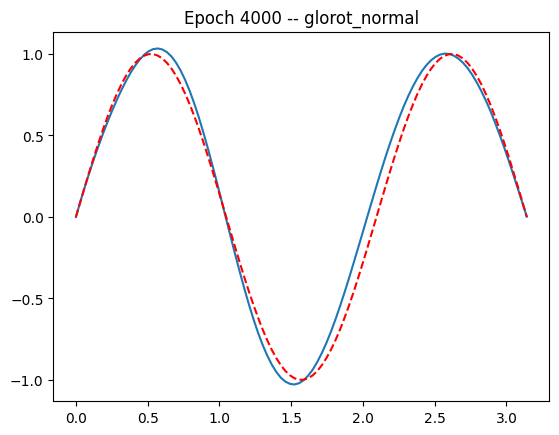

epoch 4000 -- loss 4.650142669677734
epoch 4499 -- loss -2.546279907226562555

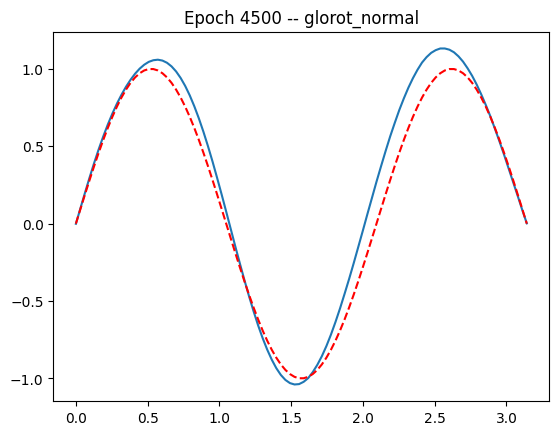

epoch 4500 -- loss 1.8144989013671875
epoch 4999 -- loss 10.985000610351562185

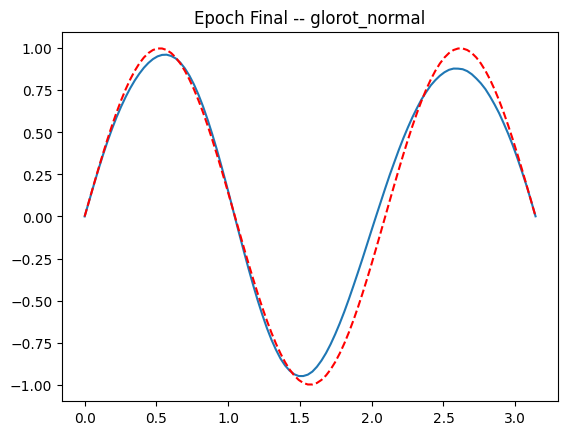

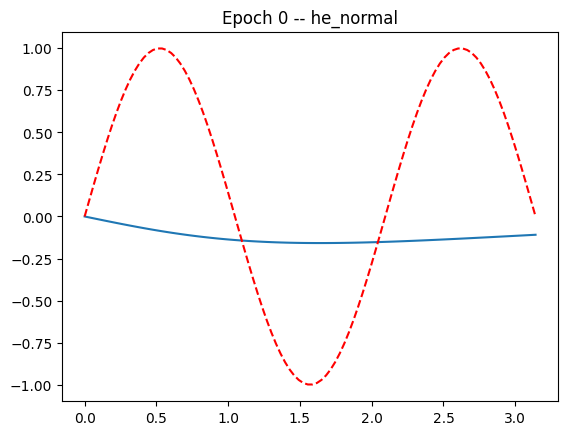

epoch 0 -- loss 4.121940612792969
epoch 499 -- loss 11.3882331848144535

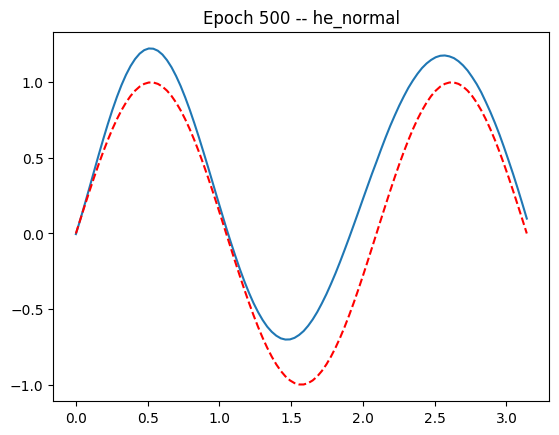

epoch 500 -- loss 5.799564361572266
epoch 999 -- loss 7.168025970458984425

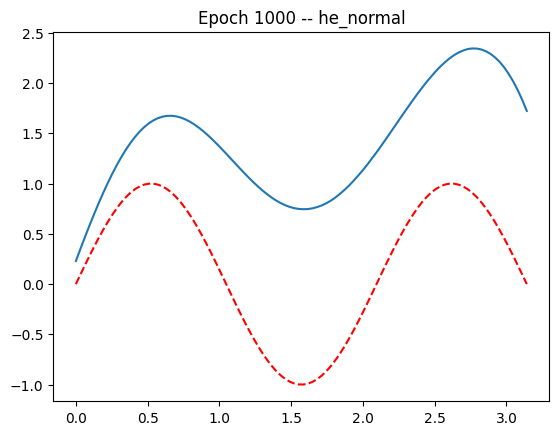

epoch 1000 -- loss 9.420978546142578
epoch 1499 -- loss 8.230766296386719525

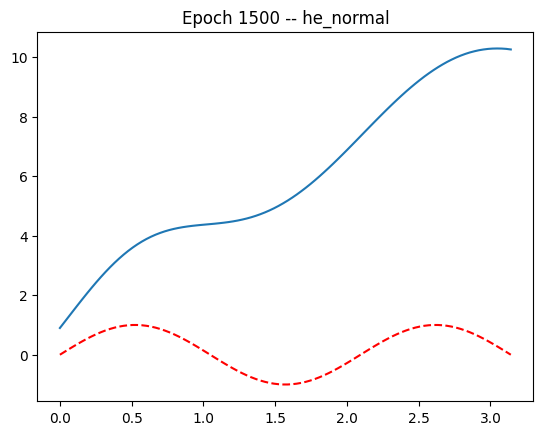

epoch 1500 -- loss 0.8025741577148438
epoch 1999 -- loss 3.087081909179687538

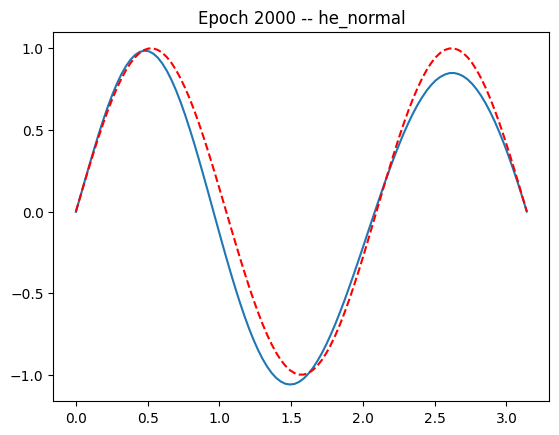

epoch 2000 -- loss -23.027812957763672
epoch 2499 -- loss 4.432067871093756255

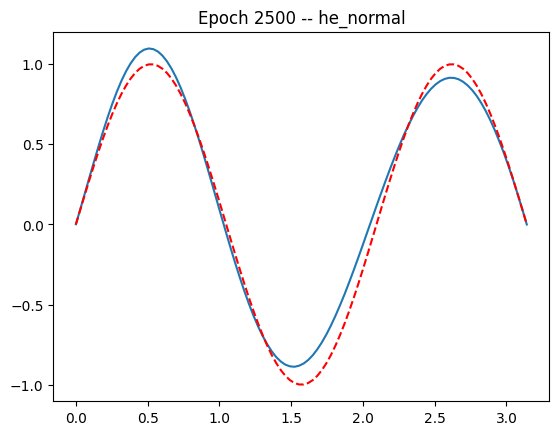

epoch 2500 -- loss 5.261867523193359
epoch 2999 -- loss 12.51451110839843855

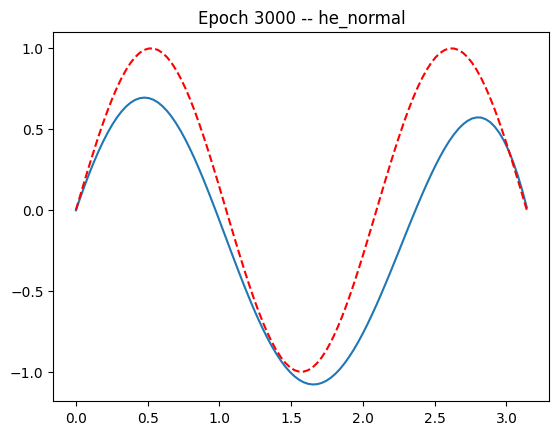

epoch 3000 -- loss 10.417383193969727
epoch 3499 -- loss -3.91405868530273445

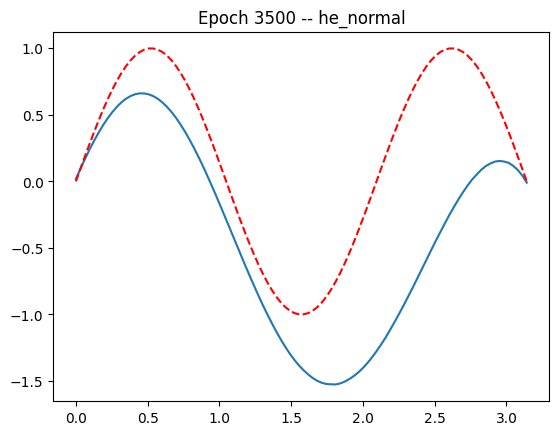

epoch 3500 -- loss 12.817268371582031
epoch 3999 -- loss 10.1179237365722666

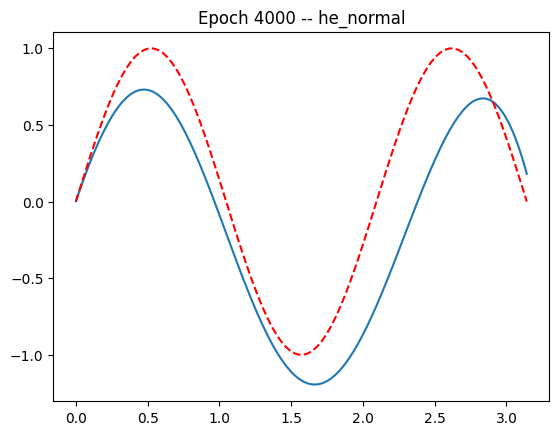

epoch 4000 -- loss 17.60552215576172
epoch 4499 -- loss 12.94612884521484465

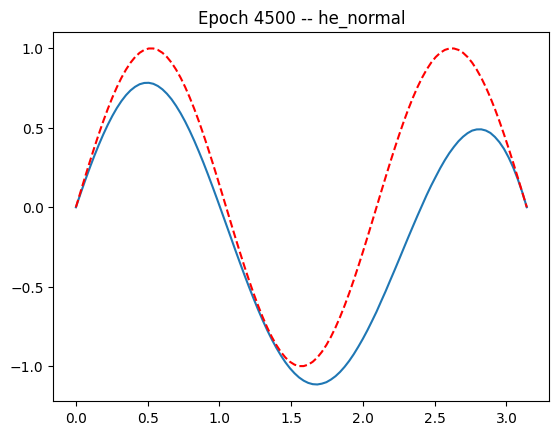

epoch 4500 -- loss 11.550376892089844
epoch 4999 -- loss -39.2987213134765655

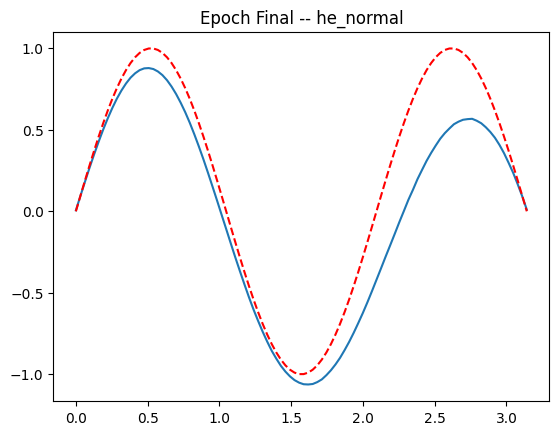

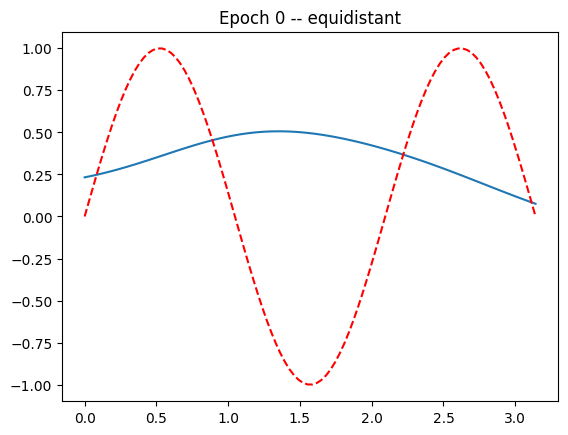

epoch 0 -- loss 0.3643150329589844
epoch 499 -- loss 0.0037040710449218755

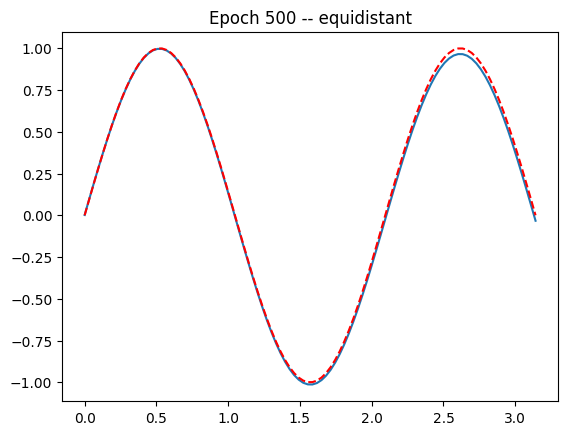

epoch 500 -- loss 0.00882720947265625
epoch 999 -- loss 0.0017814636230468755

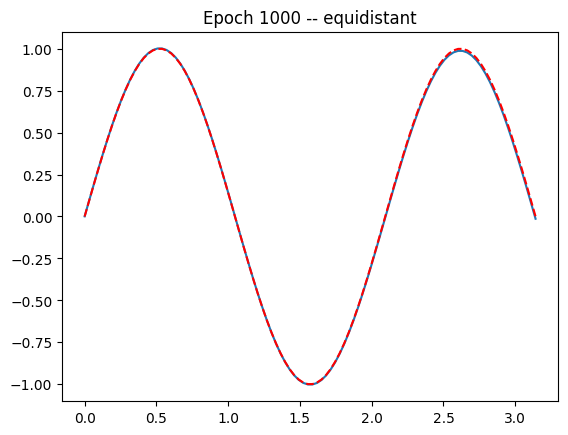

epoch 1000 -- loss 0.000774383544921875
epoch 1499 -- loss 0.0029296875443359375

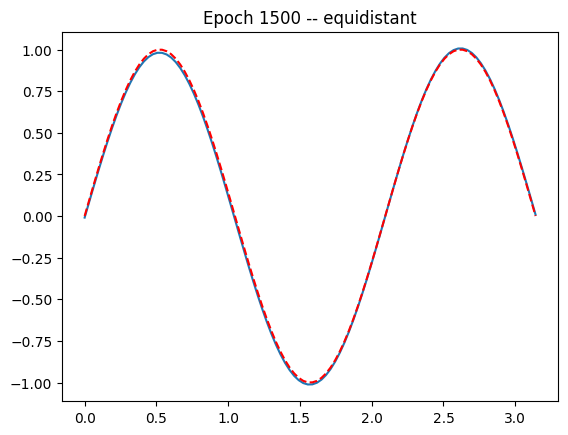

epoch 1500 -- loss 0.002544403076171875
epoch 1999 -- loss 0.0019683837890625755

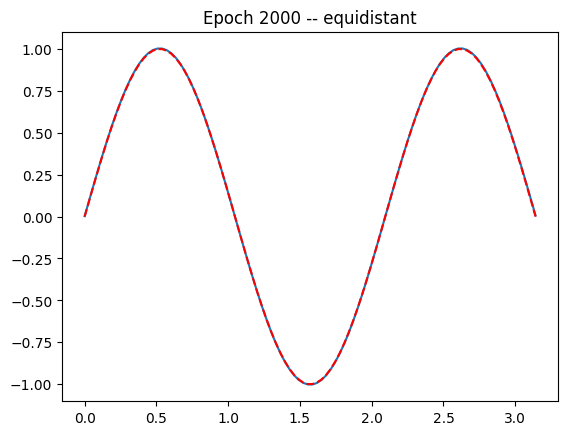

epoch 2000 -- loss 0.000881195068359375
epoch 2499 -- loss 5.340576171875e-05255

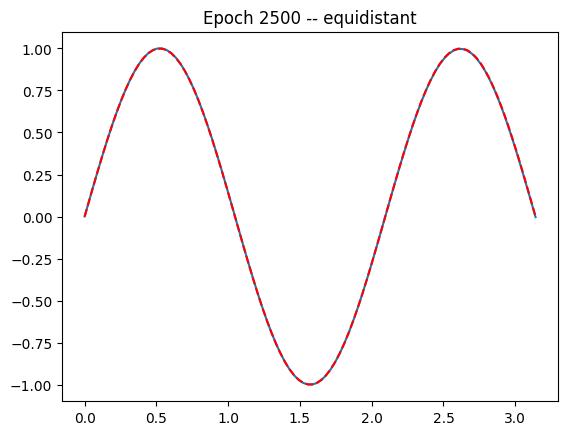

epoch 2500 -- loss 0.000885009765625
epoch 2999 -- loss 0.0032806396484375625

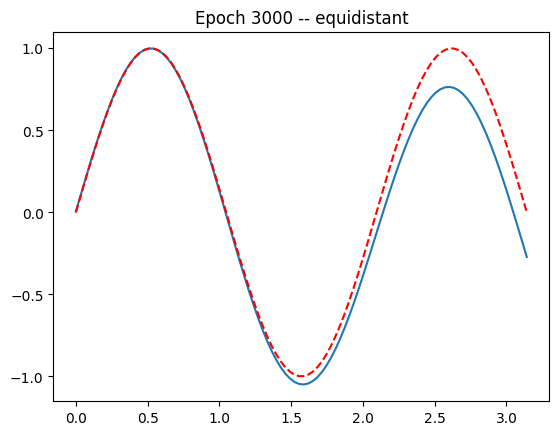

epoch 3000 -- loss 0.001949310302734375
epoch 3499 -- loss 0.0019874572753906255

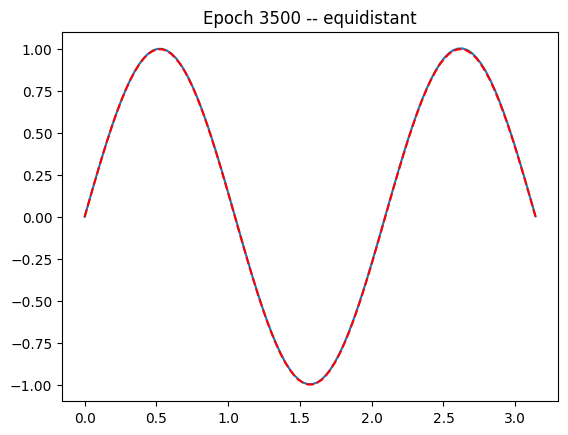

epoch 3500 -- loss -0.00046539306640625
epoch 3999 -- loss -0.000843048095703125

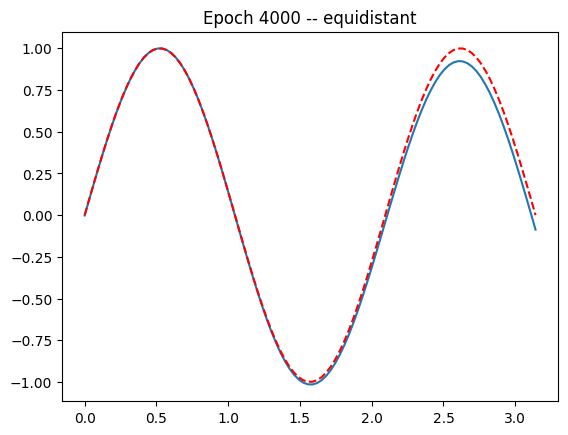

epoch 4000 -- loss 0.002899169921875
epoch 4499 -- loss 0.0018310546875375755

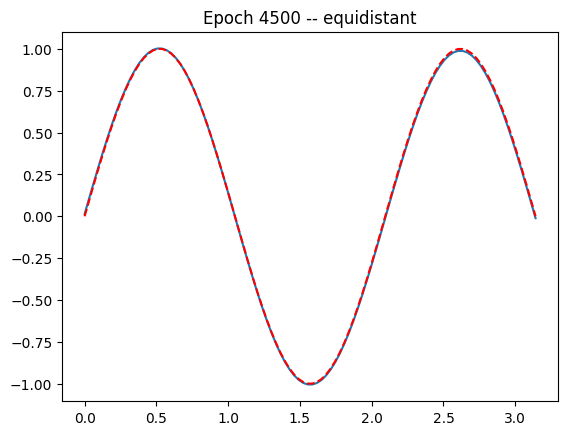

epoch 4500 -- loss -0.000339508056640625
epoch 4999 -- loss 0.0041389465332031255

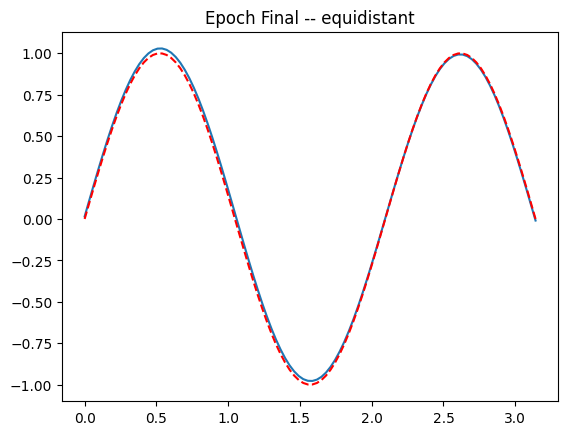

In [9]:
path = Path('model_torch_pinns_1d')
path.mkdir(exist_ok=True)

for (W, b, W_history, b_history, name) in init_data:
    net = init_net(layer=layer)
    net[0].weight = nn.Parameter(W)
    net[0].bias = nn.Parameter(b)

    optim = torch.optim.Adam(net.parameters(), lr=lr)

    train(epochs, n_points, f, u, net, optim, W_history, b_history, name=name, report_freq=500)

    torch.save(net.state_dict(), path / f'{name}.model')

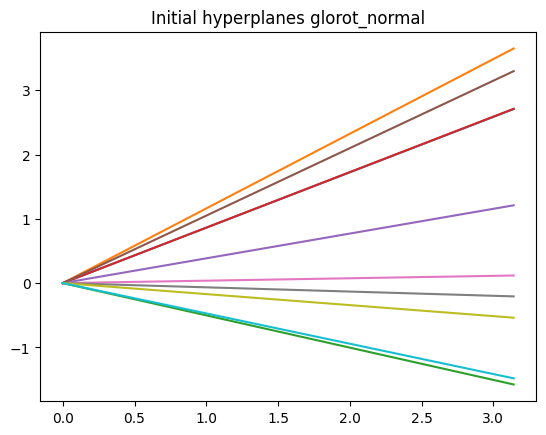

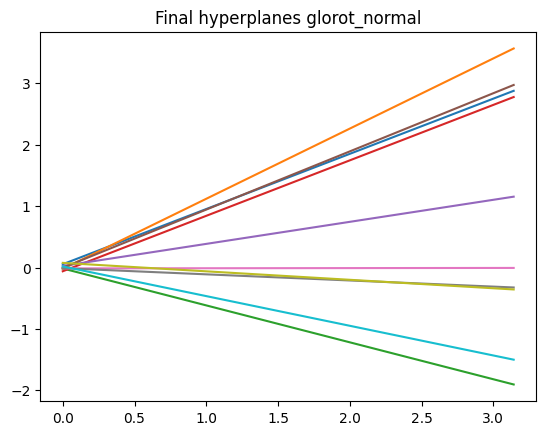

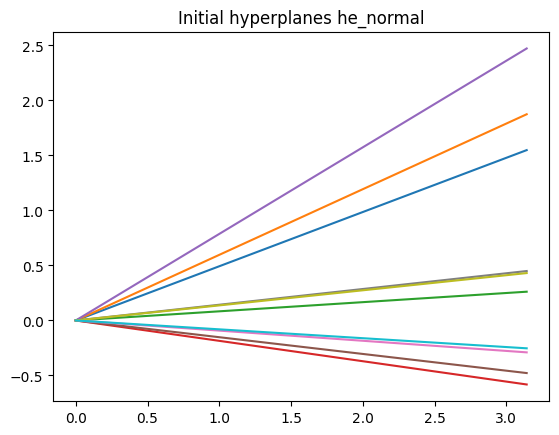

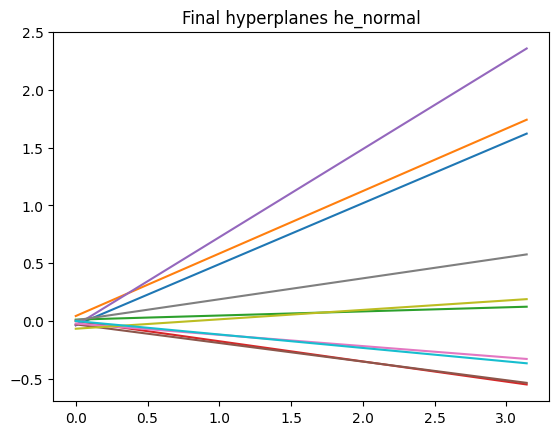

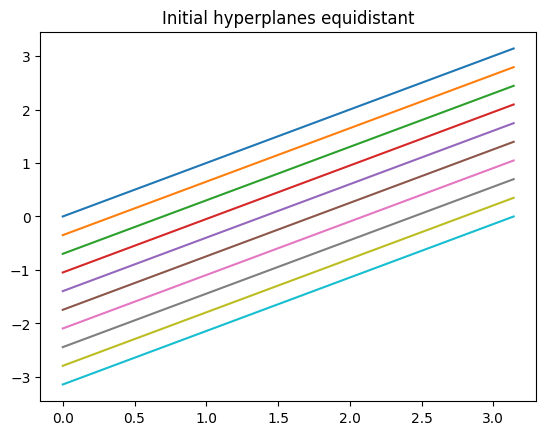

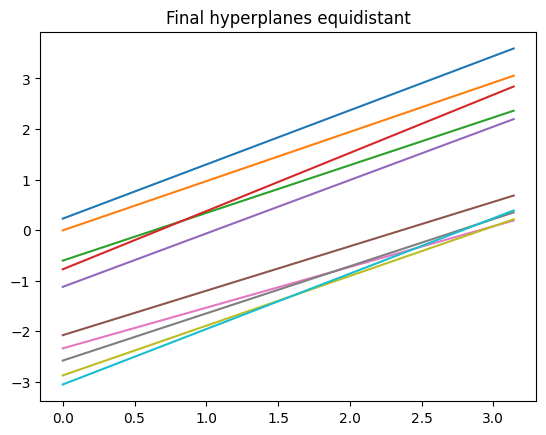

In [10]:
for (_, _, W_history, b_history, name) in init_data:
    init_W = W_history[0]
    init_b = b_history[0]

    last_W = W_history[-1]
    last_b = b_history[-1]
    
    x = torch.linspace(domain_min, domain_max, 2)
    
    plot_hyperplanes(init_W, init_b, x=x, title=f'Initial hyperplanes {name}')
    plot_hyperplanes(last_W, last_b, x=x, title=f'Final hyperplanes {name}')